In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from time import time

import os
import random
import pickle

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')


In [2]:
input_path = "data/"

on_train = pd.read_csv(input_path + 'ccf_online_stage1_train.csv',header=None)
on_train.columns = ["user_id","merchant_id","action","coupon_id","discount_rate","date_received","date"]
on_train.drop(index=0,inplace=True)

off_train = pd.read_csv(input_path + 'ccf_offline_stage1_train.csv',header=None)
off_train.columns = ["user_id","merchant_id","coupon_id","discount_rate","distance","date_received","date"]
off_train.drop(index=0,inplace=True)

off_test = pd.read_csv(input_path + 'ccf_offline_stage1_test_revised.csv',header=None)
off_test.columns = ["user_id","merchant_id","coupon_id","discount_rate","distance","date_received"]
off_test.drop(index=0,inplace=True)

## 一、数据集探索

1.查看数据表头

In [3]:
on_train.head()

,user_id,merchant_id,action,coupon_id,discount_rate,date_received,date
1,13740231,18907,2,100017492,500:50,20160513,NaN
2,13740231,34805,1,NaN,NaN,NaN,20160321
3,14336199,18907,0,NaN,NaN,NaN,20160618
4,14336199,18907,0,NaN,NaN,NaN,20160618
5,14336199,18907,0,NaN,NaN,NaN,20160618


In [4]:
off_train.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date
1,1439408,2632,NaN,NaN,0,NaN,20160217
2,1439408,4663,11002,150:20,1,20160528,NaN
3,1439408,2632,8591,20:1,0,20160217,NaN
4,1439408,2632,1078,20:1,0,20160319,NaN
5,1439408,2632,8591,20:1,0,20160613,NaN


In [5]:
off_test.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received
1,4129537,450,9983,30:5,1,20160712
2,6949378,1300,3429,30:5,NaN,20160706
3,2166529,7113,6928,200:20,5,20160727
4,2166529,7113,1808,100:10,5,20160727
5,6172162,7605,6500,30:1,2,20160708


2.查看数据集信息及缺失率

In [6]:
on_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11429826 entries, 1 to 11429826
Data columns (total 7 columns):
user_id          object
merchant_id      object
action           object
coupon_id        object
discount_rate    object
date_received    object
date             object
dtypes: object(7)
memory usage: 697.6+ MB


In [7]:
on_train.describe().T.assign(
  missing_pct=on_train.apply(lambda x : (len(x)-x.count())/float(len(x))))

,count,unique,top,freq,missing_pct
user_id,11429826,762860,14015266,5786,0.000000
merchant_id,11429826,15132,18907,425642,0.000000
action,11429826,6,0,9294534,0.000000
coupon_id,872357,27747,fixed,131546,0.923677
discount_rate,872357,64,fixed,131546,0.923677
date_received,872357,334,2.01603e+07,10749,0.923677
date,1.07739e+07,364,2.01606e+07,111344,0.057385


In [8]:
off_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754884 entries, 1 to 1754884
Data columns (total 7 columns):
user_id          object
merchant_id      object
coupon_id        object
discount_rate    object
distance         object
date_received    object
date             object
dtypes: object(7)
memory usage: 107.1+ MB


In [9]:
off_train.select_dtypes(include="object").describe().T.assign(
  missing_pct=off_train.apply(lambda x : (len(x)-x.count())/float(len(x))))

,count,unique,top,freq,missing_pct
user_id,1754884,539439,5054119,264,0.000000
merchant_id,1754884,12578,3381,131537,0.000000
coupon_id,1.05328e+06,14639,7610,43219,0.399800
discount_rate,1053282,45,30:5,270712,0.399800
distance,1.64888e+06,22,0,764719,0.060405
date_received,1.05328e+06,334,2.01601e+07,66218,0.399800
date,776984,364,2.01603e+07,9463,0.557245


In [10]:
off_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113640 entries, 1 to 113640
Data columns (total 6 columns):
user_id          113640 non-null object
merchant_id      113640 non-null object
coupon_id        113640 non-null object
discount_rate    113640 non-null object
distance         101576 non-null object
date_received    113640 non-null object
dtypes: object(6)
memory usage: 6.1+ MB


In [11]:
off_test.select_dtypes(include="object").describe().T.assign(
  missing_pct=off_test.apply(lambda x : (len(x)-x.count())/float(len(x))))

,count,unique,top,freq,missing_pct
user_id,113640,76309,6977597,97,0.00000
merchant_id,113640,1559,760,29958,0.00000
coupon_id,113640,2050,13602,29885,0.00000
discount_rate,113640,42,30:5,59318,0.00000
distance,101576,11,0,43867,0.10616
date_received,113640,31,20160703,5491,0.00000


3.删除全空的行

In [12]:
print('on_train:', on_train.shape)
print('off_train:', off_train.shape)
print('off_test:', off_test.shape)

on_train: (11429826, 7)
off_train: (1754884, 7)
off_test: (113640, 6)


In [13]:
on_train.dropna(axis=0, how='all',inplace=True)
off_train.dropna(axis=0, how='all',inplace=True)
off_test.dropna(axis=0, how='all',inplace=True)

In [14]:
print('on_train:', on_train.shape)
print('off_train:', off_train.shape)
print('off_test:', off_test.shape)

on_train: (11429826, 7)
off_train: (1754884, 7)
off_test: (113640, 6)


In [15]:
#以"null"填充空值
off_train.fillna('null',inplace=True)#将空替换成"null"
on_train.fillna('null',inplace=True)#将空替换成"null"
off_test.fillna('null',inplace=True)#将空替换成"null"

In [16]:
#将领取优惠券时间和消费时间统一成格式str
def tran_int_str(col):
    if col=='null':
        return col
    else:
        return str(int(float(col)))

on_train['date'] = on_train['date'].apply(tran_int_str)
on_train['date_received'] = on_train['date_received'].apply(tran_int_str)

off_train['date'] = off_train['date'].apply(tran_int_str)
off_train['date_received'] = off_train['date_received'].apply(tran_int_str)

off_test['date_received'] = off_test['date_received'].apply(tran_int_str)

4.查看线下数据集特征

折扣率特征

In [17]:
#折扣率的种类
off_train.discount_rate.unique()

array(['null', '150:20', '20:1', '200:20', '30:5', '50:10', '10:5',
       '100:10', '200:30', '20:5', '30:10', '50:5', '150:10', '100:30',
       '200:50', '100:50', '300:30', '50:20', '0.9', '10:1', '30:1',
       '0.95', '100:5', '5:1', '100:20', '0.8', '50:1', '200:10',
       '300:20', '100:1', '150:30', '300:50', '20:10', '0.85', '0.6',
       '150:50', '0.75', '0.5', '200:5', '0.7', '30:20', '300:10', '0.2',
       '50:30', '200:100', '150:5'], dtype=object)

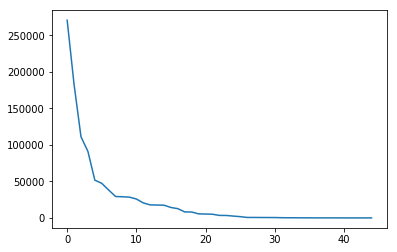

In [18]:
#特征出现的次数分布
def feature_count_display(data,feature):
    X = []
    Y = []
    for rate_type in (data[feature].unique()):
        if rate_type != "null":
            x = rate_type
            y = data[data[feature] == rate_type][feature].count()

            X.append(x)#折扣类型
            Y.append(y)#折扣类型对应的样本数

    df_tem = pd.DataFrame([X, Y]).T
    df_tem = df_tem.sort_values(by=1, ascending = False).reset_index(drop=True)

    df_tem[1].plot()
    plt.show()
    
#折扣率出现的次数
feature_count_display(off_train,"discount_rate")

折扣率特点：特定的几种折扣率出现的次数特别集中

距离特征

In [19]:
#查看距离的种类（格式不统一）
off_train.distance.unique()

array(['0', '1', 'null', '2', '10', '4', '7', '9', '3', '5', '6', '8',
       1.0, 0.0, 10.0, 4.0, 8.0, 5.0, 2.0, 3.0, 7.0, 6.0, 9.0],
      dtype=object)

In [20]:
off_train['distance'] = off_train['distance'].apply(tran_int_str)

In [21]:
#查看距离的种类（统一距离的格式）
off_train.distance.unique()

array(['0', '1', 'null', '2', '10', '4', '7', '9', '3', '5', '6', '8'],
      dtype=object)

In [22]:
#查看测试集距离的种类（统一距离的格式）
off_test.distance.unique()

array(['1', 'null', '5', '2', '0', '10', '3', '6', '7', '4', '9', '8'],
      dtype=object)

用户组合特征

In [23]:
#领取了优惠券的样本中，用户同一天领取同一商家优惠券的数量
coupon_byDate = off_train[off_train['date_received'] != "null"].groupby(
    ['user_id', 'date_received'], as_index=False)[['merchant_id']].count()
coupon_byDate.columns = ['user_id', 'date_received','count']

#领取了优惠券且使用了优惠券的样本中，用户同一天在同一商家消费的次数
buy_byDate = off_train[(off_train['date'] != "null") & (off_train['date_received'] != "null")].groupby(
    ['user_id', 'date'], as_index=False)[['merchant_id']].count()
buy_byDate.columns = ['user_id', 'date','count']

In [24]:
coupon_byDate.head()#用户同一天领取同一商家优惠券的次数

,user_id,date_received,count
0,4,20160214,1
1,4,20160607,1
2,35,20160129,2
3,35,20160130,2
4,36,20160125,2


In [25]:
buy_byDate.head()#用户同一天在同一商家消费的次数

,user_id,date,count
0,184,20160228,1
1,417,20160412,1
2,687,20160130,1
3,687,20160402,1
4,696,20160413,1


训练集和测试集的覆盖程度

In [26]:
#统一格式，否则统计的值不准确
off_test['user_id'] = off_test['user_id'].apply(tran_int_str)
off_train['user_id'] = off_train['user_id'].apply(tran_int_str)
off_test['merchant_id'] = off_test['merchant_id'].apply(tran_int_str)
off_train['merchant_id'] = off_train['merchant_id'].apply(tran_int_str)
off_test['coupon_id'] = off_test['coupon_id'].apply(tran_int_str)
off_train['coupon_id'] = off_train['coupon_id'].apply(tran_int_str)

# 测试集中出现，但训练集没出现
print('测试集新用户个数：', len(set(off_test.user_id) - set(off_train.user_id)))
print('测试集商店个数：', len(set(off_test.merchant_id) - set(off_train.merchant_id)))
print('测试集新优惠券个数：', len(set(off_test.coupon_id) - set(off_train.coupon_id)))

测试集新用户个数： 2
测试集商店个数： 1
测试集新优惠券个数： 932


训练集用户和商家基本上已经覆盖了测试集的。

训练集的优惠券覆盖不了测试集的。

核销的优惠券和只领取未核销的比例

In [27]:
###正样本
posi_sample_offLine = off_train[(off_train.coupon_id != "null") & (off_train.date != "null")]
print(posi_sample_offLine.shape)

###负样本
navi_sample_offLine = off_train[(off_train.coupon_id != "null") & (off_train.date == "null")]
print(navi_sample_offLine.shape)

(75382, 7)
(977900, 7)


负样本：正样本 = 12.9

优惠券的领取时间特征（最后几天可能会有问题）

In [28]:
tem = sorted(on_train[on_train.date_received != "null"].date_received.unique())
print('online训练集，领取优惠券的最早时期：', tem[1])
print('online训练集，领取优惠券的最后时期：', tem[-1])

tem = sorted(on_train[on_train.date != "null"].date.unique())
print('online训练集，消费的最早时期：', tem[1])
print('online训练集，消费的最后时期：', tem[-1])

tem = sorted(off_train[off_train.date_received != "null"].date_received.unique())
print('offline训练集，领取优惠券的最早时期：', tem[1])
print('offline训练集，领取优惠券的最后时期：', tem[-1])

tem = sorted(off_train[off_train.date != "null"].date.unique())
print('offline训练集，消费的最早时期：', tem[1])
print('offline训练集，消费的最后时期：', tem[-1])

tem = sorted(off_test[off_test.date_received != "null"].date_received.unique())
print('offline测试集，领取优惠券的最早时期：', tem[0])
print('offline测试集，领取优惠券的最后时期：', tem[-1])

online训练集，领取优惠券的最早时期： 20160102
online训练集，领取优惠券的最后时期： 20160615
online训练集，消费的最早时期： 20160102
online训练集，消费的最后时期： 20160630
offline训练集，领取优惠券的最早时期： 20160102
offline训练集，领取优惠券的最后时期： 20160615
offline训练集，消费的最早时期： 20160102
offline训练集，消费的最后时期： 20160630
offline测试集，领取优惠券的最早时期： 20160701
offline测试集，领取优惠券的最后时期： 20160731


领取优惠券和使用优惠券消费的组合特征

In [29]:
print('on_train:')
print('有优惠券， 购买商品：', on_train[(on_train['coupon_id'] != "null") & (on_train['date'] != "null")].shape[0])
print('有优惠券， 没有购买商品：', on_train[(on_train['coupon_id'] != "null") & (on_train['date'] == "null")].shape[0])
print('无优惠券， 购买商品：', on_train[(on_train['coupon_id'] == "null") & (on_train['date'] != "null")].shape[0])
print('无优惠券， 没有购买商品：', on_train[(on_train['coupon_id'] == "null") & (on_train['date'] == "null")].shape[0])

print('off_train:')
print('有优惠券， 购买商品：', off_train[(off_train['coupon_id'] != "null") & (off_train['date'] != "null")].shape[0])
print('有优惠券， 没有购买商品：', off_train[(off_train['coupon_id'] != "null") & (off_train['date'] == "null")].shape[0])
print('无优惠券， 购买商品：', off_train[(off_train['coupon_id'] == "null") & (off_train['date'] != "null")].shape[0])
print('无优惠券， 没有购买商品：', off_train[(off_train['coupon_id'] == "null") & (off_train['date'] == "null")].shape[0])

on_train:
有优惠券， 购买商品： 216459
有优惠券， 没有购买商品： 655898
无优惠券， 购买商品： 10557469
无优惠券， 没有购买商品： 0
off_train:
有优惠券， 购买商品： 75382
有优惠券， 没有购买商品： 977900
无优惠券， 购买商品： 701602
无优惠券， 没有购买商品： 0


训练集和测试集的覆盖度

In [32]:
print('on_train的人数：', len(set(on_train.user_id)))
print('off_train的人数：', len(set(off_train.user_id)))
print('off_train和on_train的人数交集：', len(set(on_train.user_id) & set(off_train.user_id)))
print('off_train和on_train的人数并集：', len(set(on_train.user_id) | set(off_train.user_id)))
print('\n')

print('on_train的商户数：', len(set(on_train.merchant_id)))
print('off_train的商户数：', len(set(off_train.merchant_id)))
print('off_train和on_train的商户数交集：', len(set(on_train.merchant_id) & set(off_train.merchant_id)))
print('off_train和on_train的商户数并集：', len(set(on_train.merchant_id) | set(off_train.merchant_id)))
print('\n')

print('on_train的优惠券数：', len(set(on_train.coupon_id)))
print('off_train的优惠券数：', len(set(off_train.coupon_id)))
print('off_train和on_train的优惠券数交集：', len(set(on_train.coupon_id) & set(off_train.coupon_id)))
print('off_train和on_train的优惠券数并集：', len(set(on_train.coupon_id) | set(off_train.coupon_id)))
print('\n')

print('off_test的人数：', len(set(off_test.user_id)))
print('off_train和off_test的人数交集：', len(set(off_train.user_id) & set(off_test.user_id)))
print('off_train和off_test的人数并集：', len(set(off_train.user_id) | set(off_test.user_id)))
print('\n')

print('on_train的优惠券数：', on_train.coupon_id.nunique())
print('off_train的优惠券数：', off_train.coupon_id.nunique())
print('off_train领取优惠券的记录数：', off_train[off_train.coupon_id != "null"].shape[0])
print('off_test的优惠券数：', off_test.coupon_id.nunique())
print('off_test领取优惠券的记录数：', off_test[off_test.coupon_id != "null"].shape[0])

on_train的人数： 762860
off_train的人数： 539438
off_train和on_train的人数交集： 3353
off_train和on_train的人数并集： 1298945


on_train的商户数： 15132
off_train的商户数： 8415
off_train和on_train的商户数交集： 0
off_train和on_train的商户数并集： 23547


on_train的优惠券数： 27748
off_train的优惠券数： 9739
off_train和on_train的优惠券数交集： 1
off_train和on_train的优惠券数并集： 37486


off_test的人数： 76309
off_train和off_test的人数交集： 76307
off_train和off_test的人数并集： 539440


on_train的优惠券数： 27748
off_train的优惠券数： 9739
off_train领取优惠券的记录数： 1053282
off_test的优惠券数： 2050
off_test领取优惠券的记录数： 113640


5.数据集划分

In [61]:
###测试集数据
df_test = off_test

df_test_feat_offline = off_train[((off_train.date_received != "null") & 
                                  (off_train.date_received >= "20160315") & 
                                  (off_train.date_received <= "20160630")) #线下3月15号到6月30号之间领取优惠券的样本（领取了优惠券的样本）
                                 | 
                                 ((off_train.date != "null") & 
                                  (off_train.date >= "20160315") & 
                                  (off_train.date <= "20160630"))]#线下3月15号到6月30号之间消费的样本（包括领取和未领取优惠券的样本）

df_test_feat_online = on_train[((on_train.date_received != "null") & 
                                (on_train.date_received >= "20160315") & 
                                (on_train.date_received <= "20160630")) #线上3月15号到6月30号之间领取优惠券的样本
                               | 
                               ((on_train.date != "null") & 
                                (on_train.date >= "20160315") & 
                                (on_train.date <= "20160630"))]#线上3月15号到6月30号之间消费的样本

print('df_test.shape:', df_test.shape)

###训练集_1数据
df_train1 = off_train[(off_train.date_received != "null") & 
                      (off_train.date_received >= "20160515") & 
                      (off_train.date_received <= "20160615")]

df_train1_feat_offline = off_train[((off_train.date_received != "null") & 
                                    (off_train.date_received >= "20160201") & 
                                    (off_train.date_received <= "20160514")) 
                                   | 
                                  ((off_train.date != "null") & 
                                   (off_train.date >= "20160201") & 
                                   (off_train.date <= "20160514"))]
df_train1_feat_online = on_train[((on_train.date_received != "null") & 
                                  (on_train.date_received >= "20160201") & 
                                  (on_train.date_received <= "20160514")) 
                                 | 
                                ((on_train.date != "null") & 
                                 (on_train.date >= "20160201") & 
                                 (on_train.date <= "20160514"))]

print('df_train1.shape:', df_train1.shape)

###训练集_2数据
df_train2 = off_train[(off_train.date_received != "null") & 
                      (off_train.date_received >= "20160414") & 
                      (off_train.date_received <= "20160514")]

df_train2_feat_offline = off_train[((off_train.date_received != "null") & 
                                    (off_train.date_received >= "20160101") & 
                                    (off_train.date_received <= "20160413")) 
                                   | 
                                  ((off_train.date != "null") & 
                                   (off_train.date >= "20160101") & 
                                   (off_train.date <= "20160413"))]
df_train2_feat_online = on_train[((on_train.date_received != "null") & 
                                  (on_train.date_received >= "20160101") & 
                                  (on_train.date_received <= "20160413")) 
                                 | 
                                ((on_train.date != "null") & 
                                 (on_train.date >= "20160101") & 
                                 (on_train.date <= "20160413"))]                                          

print('df_train2.shape:', df_train2.shape)

TypeError: '>=' not supported between instances of 'int' and 'str'